# Linear Regression and Temperature

In this notebook, we'll look at using linear regression to study changes in temperature.

## Setup

In [3]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%config InlineBackend.figure_format ='retina'

## Getting our data

We'll be getting data from [North America Land Data Assimilation System (NLDAS)](https://wonder.cdc.gov/NASA-NLDAS.html), which provides the daily average temperature from 1979-2011 for the United States.

For the next step, you will need to choose some settings in the data request form. These are:

- GroupBy: Month Day, Year
- Your State
- Export Results (check box)
- Show Zero Values (check box)

>1) Download the data for your home state (or state of your choosing) and upload it to M2 in your work directory.

# Loading our data

In [4]:
df = pd.read_csv('North America Land Data Assimilation System (NLDAS) Daily Air Temperatures and Heat Index (1979-2011).txt',delimiter='\t',skipfooter=14,engine='python')

In [5]:
df

,Notes,"Month Day, Year","Month Day, Year Code",State,State Code,Avg Daily Max Air Temperature (F)
0,NaN,"Jan 01, 1979",1979/01/01,Texas,48.0,29.03
1,Total,"Jan 01, 1979",1979/01/01,NaN,NaN,29.03
2,NaN,"Jan 02, 1979",1979/01/02,Texas,48.0,31.35
3,Total,"Jan 02, 1979",1979/01/02,NaN,NaN,31.35
4,NaN,"Jan 03, 1979",1979/01/03,Texas,48.0,41.66
...,...,...,...,...,...,...
24102,NaN,"Dec 30, 2011",2011/12/30,Texas,48.0,68.61
24103,Total,"Dec 30, 2011",2011/12/30,NaN,NaN,68.61
24104,NaN,"Dec 31, 2011",2011/12/31,Texas,48.0,73.49
24105,Total,"Dec 31, 2011",2011/12/31,NaN,NaN,73.49


### Clean the data

>2) Drop any rows that have the value "Total" in the Notes column, then drop the Notes column

In [6]:
df = df[df.Notes != 'Total']
df = df.drop('Notes', 1)

>3) Make a column called Date that is in the pandas datetime format

In [7]:
df['Date'] = df['Month Day, Year'].astype('datetime64[ns]')

>4) Make columns for 'Year', 'Month', and 'Day' by splitting the column 'Month Day, Year'

In [8]:
df["Day"] = df['Date'].map(lambda x: x.day)
df["Month"] = df['Date'].map(lambda x: x.month)
df["Year"] = df['Date'].map(lambda x: x.year)

In [9]:
df['DateInt'] = df['Date'].astype(int)/10e10 # This will be used later

## Generating a scatter plot

> 4) Use df.plot.scatter to plot 'Date' vs 'Avg Daily Max Air Temperature (F)'. You might want to add figsize=(50,5) as an argument to make it more clear what is happening.

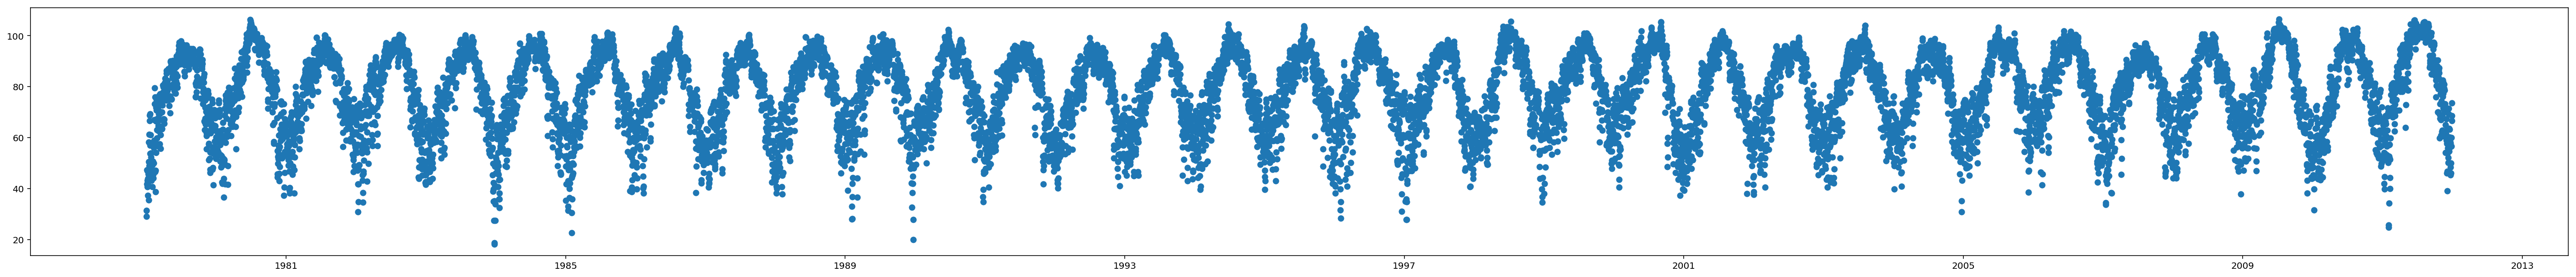

In [10]:
plt.figure(figsize=(50, 5))
plt.scatter(df['Date'], df['Avg Daily Max Air Temperature (F)'])

>5) Describe your plot.

In [11]:
df.describe()

,State Code,Avg Daily Max Air Temperature (F),Day,Month,Year,DateInt
count,12053.0,12053.000000,12053.000000,12053.000000,12053.000000,1.205300e+04
mean,48.0,78.142387,15.729362,6.523023,1994.999336,8.046432e+06
std,0.0,15.276975,8.800341,3.448821,9.522102,3.006328e+06
min,48.0,18.160000,1.000000,1.000000,1979.000000,2.839968e+06
25%,48.0,66.890000,8.000000,4.000000,1987.000000,5.443200e+06
50%,48.0,80.580000,16.000000,7.000000,1995.000000,8.046432e+06
75%,48.0,91.020000,23.000000,10.000000,2003.000000,1.064966e+07
max,48.0,106.520000,31.000000,12.000000,2011.000000,1.325290e+07


### Adding colors for our graph

In [12]:
# No need to edit this unless you want to try different colors or a pattern other than colors by month
cmap = matplotlib.cm.get_cmap("nipy_spectral", len(df['Month'].unique())) # Builds a discrete color mapping using a built in matplotlib color map

c = []
for i in range(cmap.N): # Converts our discrete map into Hex Values
    rgba = cmap(i)
    c.append(matplotlib.colors.rgb2hex(rgba))

df['color']=[c[int(i-1)] for i in df['Month'].astype(int)] # Adds a column to our dataframe with the color we want for each row

>6) Make the same plot as 4) but add color by adding the argument c=df\['color'\] to our plotting command.

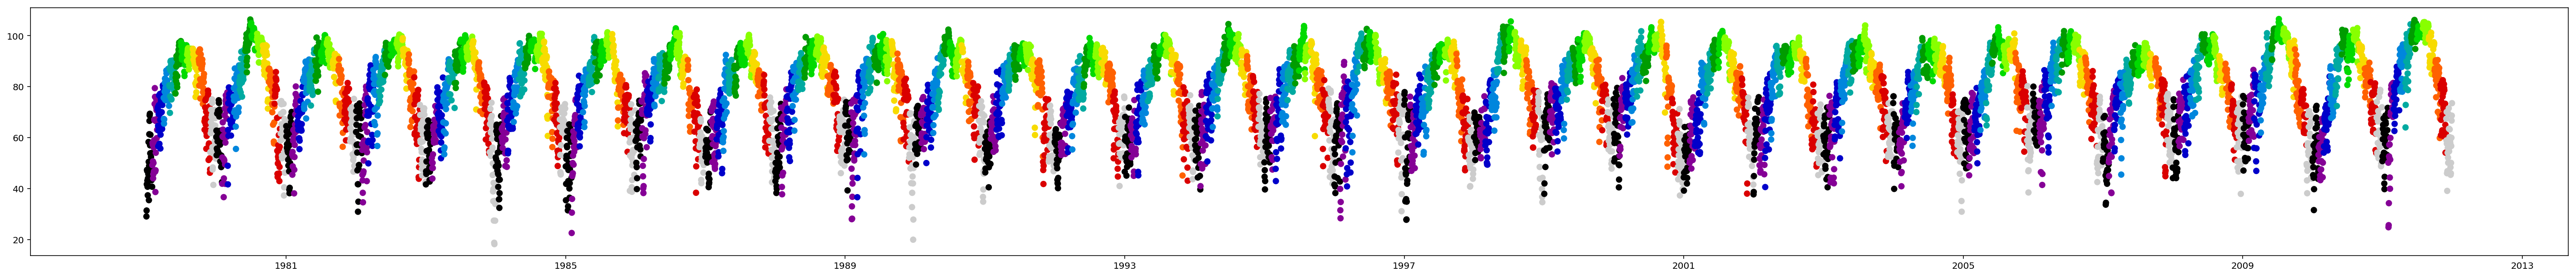

In [13]:
plt.figure(figsize=(50, 5))
plt.scatter(df['Date'], df['Avg Daily Max Air Temperature (F)'], c=df['color'])

## Pick a subset of the data

>7) Select a 6 month period from the data. # Hint use logic and pd.datetime(YYYY, MM, DD)

In [14]:
subset = df[(df['Date'] > '2000-6-1') & (df['Date'] <= '2000-12-1')]

>8) Plot the subset using the the same code you used in 6). You can change the figsize if needed.

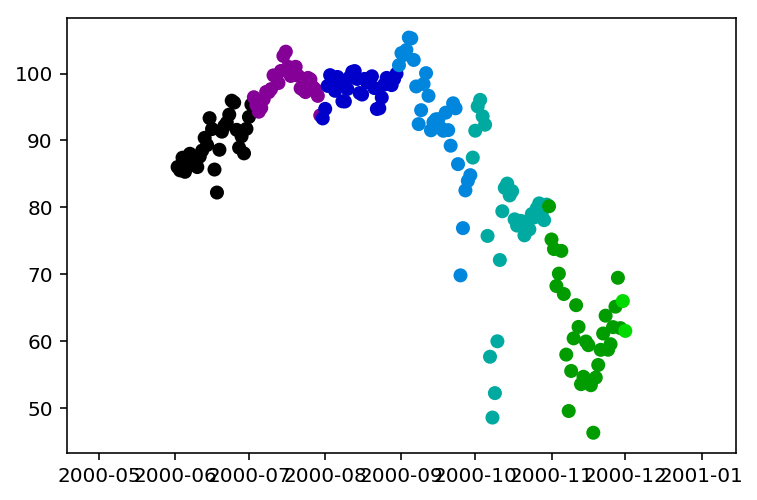

In [15]:
plt.scatter(subset['Date'], subset['Avg Daily Max Air Temperature (F)'], c=df['color'])

## Linear Regression

We are going to use a very [simple linear regression model](https://en.wikipedia.org/wiki/Simple_linear_regression). You may implement a more complex model if you wish.

The method described here is called the least squares method and is defined as:

$m = \frac{\sum_{i=1}^{n}(x_i-\bar{x})(y_i-\bar{y}))}{\sum_{i=1}^{n}(x_i-\bar{x})^2}$

$b = \bar{y} - m\bar{x}$

Where $\bar{x}$ and $\bar{y}$ are the average value of $x$ and $y$ respectively.

First we need to define our X and Y values.

In [16]:
X=subset['DateInt'].values
Y=subset['Avg Daily Max Air Temperature (F)'].values

In [21]:
def lin_reg(x,y):
    # Calculate the average x and y
    x_avg = np.mean(x)
    y_avg = np.mean(y)

    num = 0
    den = 0
    for i in range(len(x)): # This represents our sums
        num = num + (x[i] - x_avg)*(y[i] - y_avg) # Our numerator
        den = den + (x[i] - x_avg)**2 # Our denominator
    # Calculate slope
    m = num / den
    # Calculate intercept
    b = y_avg - m*x_avg

    print (m, b)
    
    # Calculate our predicted y values
    y_pred = m*x + b
    
    return y_pred

In [54]:
Y_pred = lin_reg(X,Y)

3.072410840971274e-07 75.67019246681011


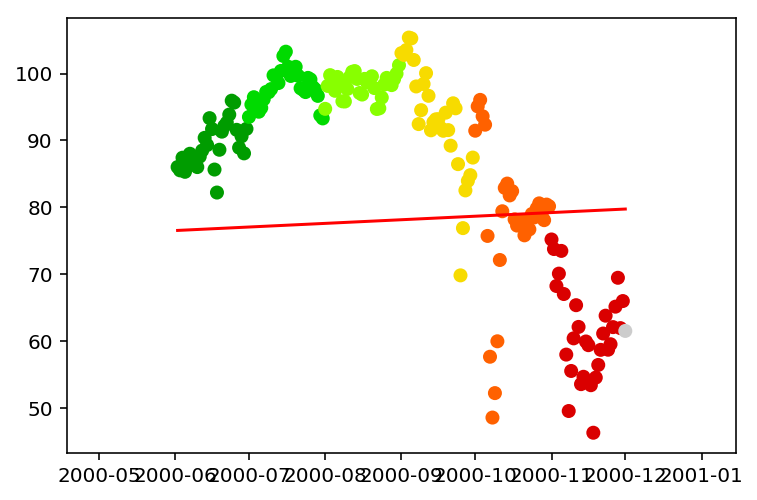

In [55]:
plt.scatter(x=subset['Date'], y=subset['Avg Daily Max Air Temperature (F)'],c=subset['color'])
plt.plot([min(subset['Date'].values), max(subset['Date'].values)], [min(Y_pred), max(Y_pred)], color='red') # best fit line
plt.show()

>9) What are the slope and intercept of your best fit line?

In [62]:
from scipy.stats import linregress

fit = np.polyfit(np.arange(subset['Date'].size), subset['Avg Daily Max Air Temperature (F)'], deg=1)
slope = str(fit[0])
intercept = str(fit[1])

print ("Slope : " + str(fit[0]))
print ("Intercept : " + str(fit[1]))

Slope : -0.19214313128069366
Intercept : 103.75704680446663


>10) What are the minimum and maximum Y values of your best fit line? Is your slope positive or negative?

In [64]:
#Calculate minimum and maximum Y values
minY = min(Y_pred)
maxY = max(Y_pred)

#Calculate slope sign
sign = ""
if(slope > "0"):
    sign = "Positive"
elif(slope == "0"):
    sign = "Zero"
else:
    sign = "Negative"

print("Maximum Y value : ", maxY ,"\nMinimum Y value : ", minY,"\nSlope : ", sign)

Maximum Y value :  79.74202660127659 
Minimum Y value :  76.54274731393126 
Slope :  Negative


## Putting it all together

>11) Generate a best fit line for the full data set and plot the line over top of the data.

3.072410840971274e-07 75.67019246681011


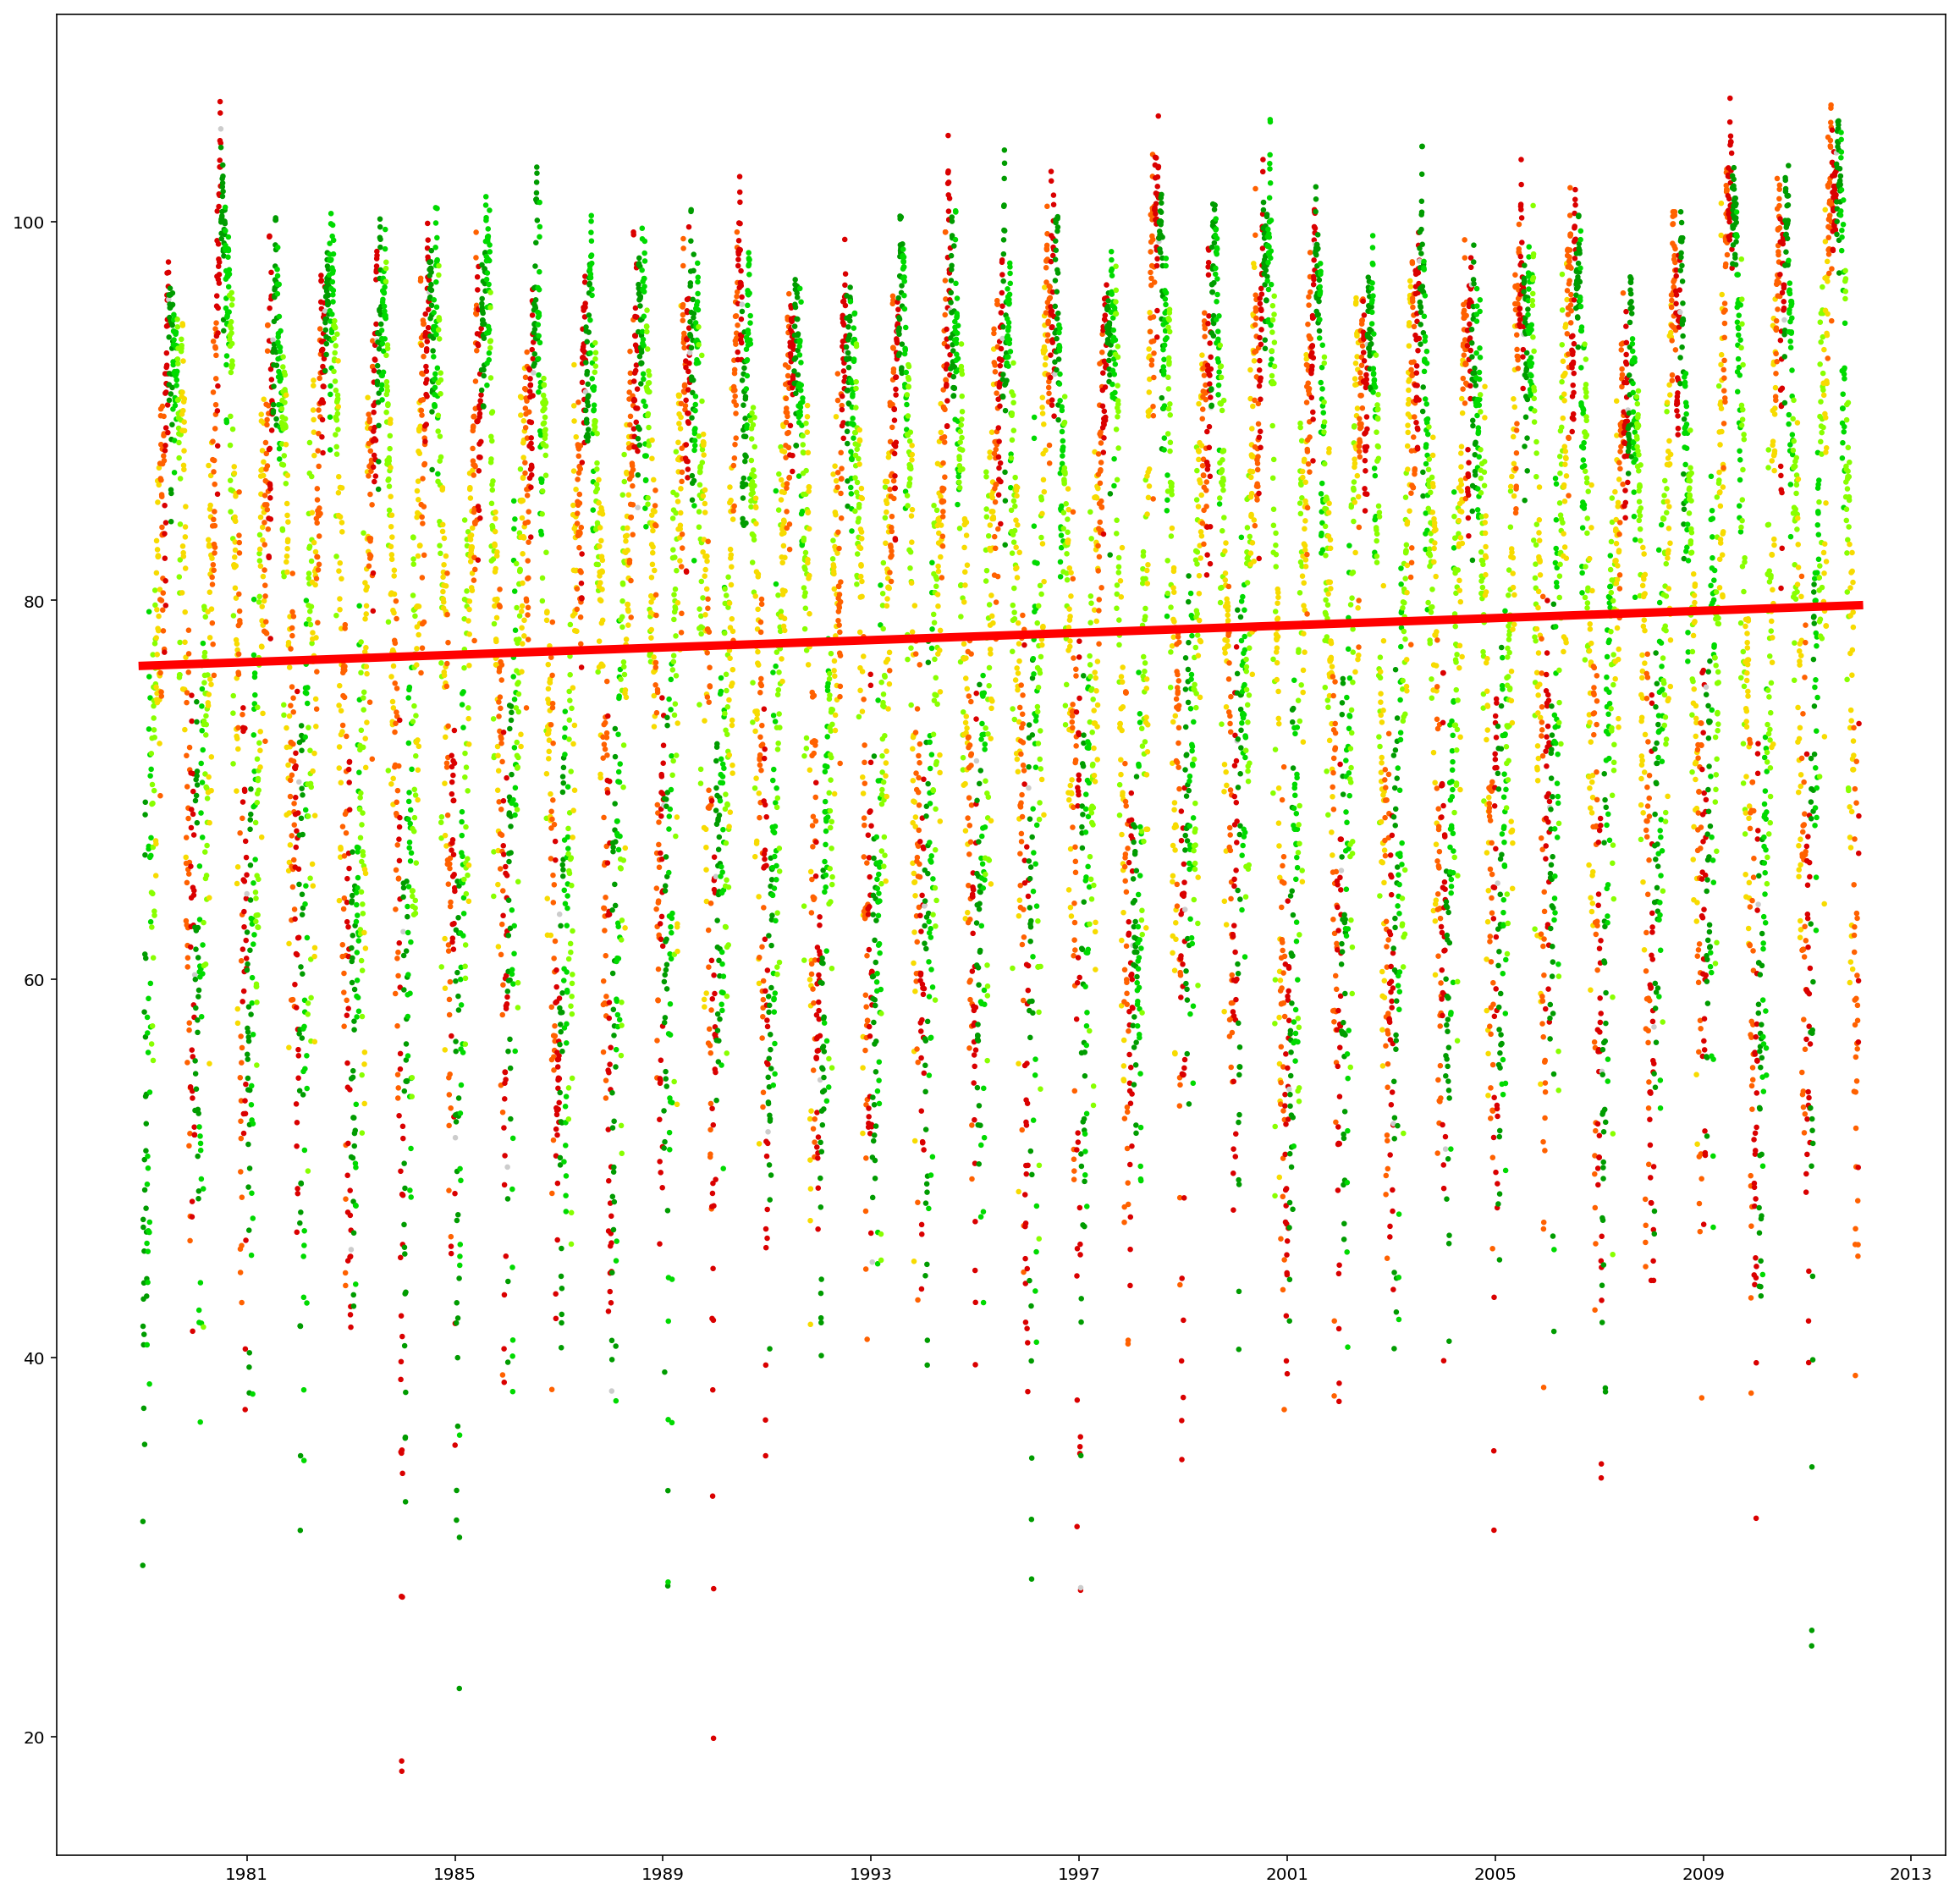

In [65]:
#Set data to be used
X=df['DateInt'].values
Y=df['Avg Daily Max Air Temperature (F)'].values

#Generate Best Fit Line
Y_pred = lin_reg(X,Y);

#Graph data set
plt.subplots(figsize=(20, 20))
plt.scatter(x=df['Date'], y=df['Avg Daily Max Air Temperature (F)'],c=subset['color'], s=5)

#Plot best fit line
plt.plot([min(df['Date'].values), max(df['Date'].values)], [min(Y_pred), max(Y_pred)], color='red', lw=5) # best fit line

plt.show()

>12) Is the slope positive or negative? What do you think that means?

In [67]:
#Calculate Slope
fit = np.polyfit(np.arange(df['Date'].size), df['Avg Daily Max Air Temperature (F)'], deg=1)
slope = str(fit[0])

sign = ""
if(slope > "0"):
    sign = "Positive"
elif(slope == "0"):
    sign = "Zero"
else:
    sign = "Negative"
    
print ("The Slope : " + str(fit[0]) + " is " + sign)

The Slope : 0.00026545629665992147 is Positive
